# ESI

Check out ESI for the cohort and how ESI correlates with actual moveing into the ICU (using label max24).

Check the trajectories for patients that the simple model got right but the complex model got wrong.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

In [2]:
# read in data files
datadir = "/home/eulalio/BMI212/2019_data/"

adt_file = datadir + "traige_cohort_2019_adt.csv"
csn_file = datadir + "cohort_2019_csns.csv"
results_file = datadir + "results_gbw.csv"
labels_file = datadir + "triage_cohort_2019_all_labels.csv"
demo_file = datadir + "cohort_demo.csv"


full_adt = pd.read_csv(adt_file)
csns = pd.read_csv(csn_file)
results = pd.read_csv(results_file)
labels = pd.read_csv(labels_file)
demo = pd.read_csv(demo_file)

In [3]:
print(labels.columns)
print(demo.columns)

Index(['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded',
       'label_max24', 'admit_time', 'admit_label', 'label_24hr_recent',
       'label_12hr_recent', 'has_admit_label', 'first_label',
       'first_label_time_since_admit', 'acute_to_critical_label',
       'critical_to_acute_label'],
      dtype='object')
Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time_jittered', 'label',
       'inpatient_data_id_coded', 'esi', 'hosp_admsn_time_jittered',
       'ed_time_hr', 'admtimediff', 'admit_time', 'ed_time_min', 'gender',
       'race', 'recent_height', 'recent_weight_kg', 'recent_date', 'age',
       'medis', 'English'],
      dtype='object')


We want to use the ESI from the demo table and the labels from the labels table.

In [4]:
labels_demo = labels.merge(demo, on='pat_enc_csn_id_coded')

labels_demo.pat_enc_csn_id_coded.nunique()

42995

In [5]:
# there are too many csns above, we need to get this down to the final set of csns

# filter down to csns in our cohort - should be 41,654 csns
adt = full_adt[full_adt.pat_enc_csn_id_coded.isin(csns.pat_enc_csn_id_coded)]
adt.pat_enc_csn_id_coded.nunique() # needs to be 61,654

41654

In [6]:
# now subset down to csns from the adt table
labels_demo_sub = labels_demo[labels_demo.pat_enc_csn_id_coded.isin(csns.pat_enc_csn_id_coded)]
labels_demo_sub.pat_enc_csn_id_coded.nunique()

41642

## Now we have final cohort set

We're down to the final set of 61,642 csns, so we can look at data now.

In [7]:
labels_demo_sub.columns

Index(['anon_id_x', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded_x',
       'label_max24', 'admit_time_x', 'admit_label', 'label_24hr_recent',
       'label_12hr_recent', 'has_admit_label', 'first_label',
       'first_label_time_since_admit', 'acute_to_critical_label',
       'critical_to_acute_label', 'anon_id_y', 'admit_time_jittered', 'label',
       'inpatient_data_id_coded_y', 'esi', 'hosp_admsn_time_jittered',
       'ed_time_hr', 'admtimediff', 'admit_time_y', 'ed_time_min', 'gender',
       'race', 'recent_height', 'recent_weight_kg', 'recent_date', 'age',
       'medis', 'English'],
      dtype='object')

In [8]:
labels_demo_sub.head()

,anon_id_x,pat_enc_csn_id_coded,inpatient_data_id_coded_x,label_max24,admit_time_x,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,...,admit_time_y,ed_time_min,gender,race,recent_height,recent_weight_kg,recent_date,age,medis,English
0,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0.0,0,0.0,1,0.0,...,2017-06-24 12:56:00,463,Female,White,154.94,54.43,2019-01-01,22,0,1
1,JCcb65bd,131072545278,14327919,0,2015-02-18 20:54:00+00:00,0.0,0,0.0,1,0.0,...,2015-02-18 05:24:00,270,Female,Other,144.78,35.00,2019-01-01,85,0,1
2,JCcb65e1,131239638605,26535361,0,2017-11-08 09:51:00+00:00,0.0,0,0.0,1,0.0,...,2017-11-08 09:51:00,159,Female,Native American,147.32,61.69,2019-10-25,71,0,0
3,JCcb65e1,131265028886,35078537,0,2019-04-17 16:25:00+00:00,0.0,0,0.0,1,0.0,...,2019-04-17 16:25:00,624,Female,Native American,147.32,61.69,2019-10-25,72,0,0
4,JCcb6601,131125490360,16936826,0,2015-09-15 04:10:00+00:00,0.0,0,0.0,1,0.0,...,2015-09-15 02:57:00,277,Male,White,182.88,125.65,2020-03-31,69,1,1


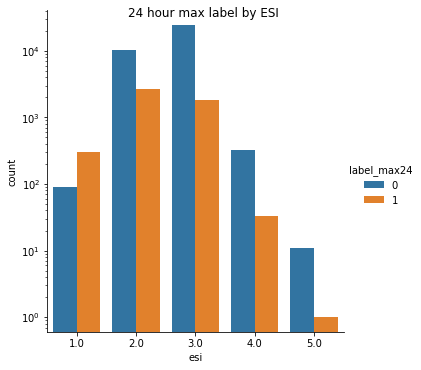

In [9]:
# check out label distribution for each ESI level for MAX label
p = sns.catplot(data=labels_demo_sub,
           x='esi',
            kind='count',
           hue='label_max24')
p.fig.suptitle("24 hour max label by ESI")
p.fig.get_axes()[0].set_yscale('log')
plt.show()

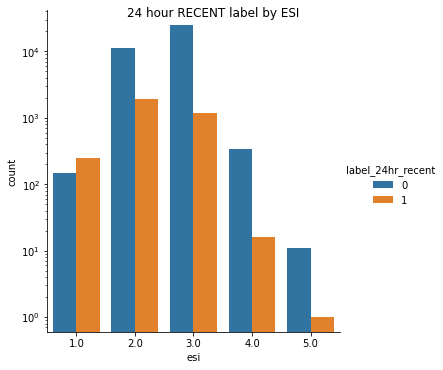

In [10]:
# check out label distribution for each ESI level for RECENT label
p = sns.catplot(data=labels_demo_sub,
           x='esi',
            kind='count',
           hue='label_24hr_recent')
p.fig.suptitle("24 hour RECENT label by ESI")
p.fig.get_axes()[0].set_yscale('log')
plt.show()

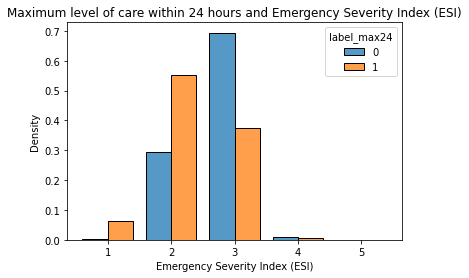

In [45]:
# create density plot
p = sns.histplot(data=labels_demo_sub,
           x='esi',
           hue='label_max24',
               discrete=True,
                stat='density',
               common_norm=False,
                 multiple='dodge',
                 shrink=0.8
               )
# p.fig.suptitle("24 hour max label by ESI")
# p.fig.get_axes()[0].set_yscale('log')
p.set_title("Maximum level of care within 24 hours and Emergency Severity Index (ESI)")
p.set(xlabel='Emergency Severity Index (ESI)')
plt.show()